In [174]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
from simplejson import JSONDecodeError
from collections import Counter 
import pprint 
import math
import argparse 
import os
import collections
import json
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import random
import time 


In [175]:
def parse_json(filepath):
    """
    function used to parse json of each commit json file

    Args:
        filepath_list - list of filepaths

    Returns:
        files_json - list object contains parsed information

    """

    files_json = []

    # each commits
    files = os.listdir(filepath)
    for path in files:
        if os.stat(filepath + path).st_size != 0 and path != 'desktop.ini':
            with open(filepath + path, encoding="utf8") as f:
                data = json.load(f)
                files_list = []
                # each file in commits
                for file in data['files']:
                    # parse only cluster file
                    for key in file.keys():
                        if re.match('^.*_cluster$', key):
                            actions_list = []
                            actions = file[key]['actions']
                            # each action in file
                            for action in actions:
                                actions_list.append(action['root'])
                            files_list.append(actions_list)
            if len(files_list) != 0:
                files_json.append(files_list)
    # return
    return files_json


folder_path = 'C:\\Users\\ichel\\Desktop\\shared_ReFiles\\AllFiles_Research\\'
all_files = parse_json(folder_path)

In [176]:
def preprocess_roots(files_data):
    counting = {}
    for file_index, files in enumerate(files_data):
        for root_index, roots in enumerate(files):
            for action_index, actions in enumerate(roots):
                temp = actions.split(' at ')[0].strip()
                tempq = []
                if temp.startswith('INS'):
                    tempq.append('INS')
                    words = [temp.split('INS ')[1].split('to ')[0].strip()] + [
                        temp.split('INS ')[1].rsplit('to ')[-1].strip()
                    ]
                    for items in words:
                        items = items.split(':')[0].strip()
                        tempq.append(items)
                    if tempq[1] == 'TextElement' and tempq[-1] not in ['TagElement', 'TextElement']:
                        tempq[-1] = ''
                    temp = '_'.join(tempq)

                if temp.startswith('UPDATE'):
                    temp = 'UPDATE'
                if temp.startswith('MOVE'):
                    temp2 = temp.split('from ')[1].strip()
                    tempq.append('MOVE')
                    tempq.append(temp2.split(':')[0].strip())
                    temp = '_'.join(tempq)

                if temp.startswith('DEL'):
                    tempq.append('DEL')
                    tempq.append(temp.split('DEL ')[1].split(':')[0].strip())
                    temp = '_'.join(tempq)
                temp = temp.replace(' ', '_')
                counting[temp] = counting.get(temp, 0) + 1
                files_data[file_index][root_index][action_index] = temp
    dic = {}
    i = 0
    for k, v in counting.items():
        dic[k] = i
        i += 1
    return dic, files_data, counting

In [177]:
dic, datas, freq_dict = preprocess_roots(all_files)
rev_dic = dict(zip(dic.values(), dic.keys()))

<sample training data>:  ['INS_MethodDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration UPDATE INS_TagElement_TagElement INS_TextElement_TagElement INS_FieldAccess_ArrayAccess DEL_SimpleName', 'INS_TypeDeclaration_TypeDeclaration INS_FieldDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration MOVE_TypeDeclaration INS_Javadoc_MethodDeclaration MOVE_Block INS_Javadoc_MethodDeclaration INS_SimpleType_MethodDeclaration UPDATE MOVE_MethodDeclaration INS_Modifier_FieldDeclaration INS_Modifier_FieldDeclaration INS_ExpressionStatement_Block UPDATE INS_QualifiedName_ReturnStatement INS_FieldAccess_Assignment INS_ClassInstanceCreation_Assignment INS_QualifiedName_MethodInvocation INS_QualifiedName_Assignment INS_QualifiedName_MethodInvocation INS_QualifiedName_MethodInvocation INS_QualifiedName_MethodInvocation INS_QualifiedName_MethodInvocation INS_QualifiedName_MethodInvocation DEL_Modifier DEL_SimpleName DEL_MethodInvocation DEL_

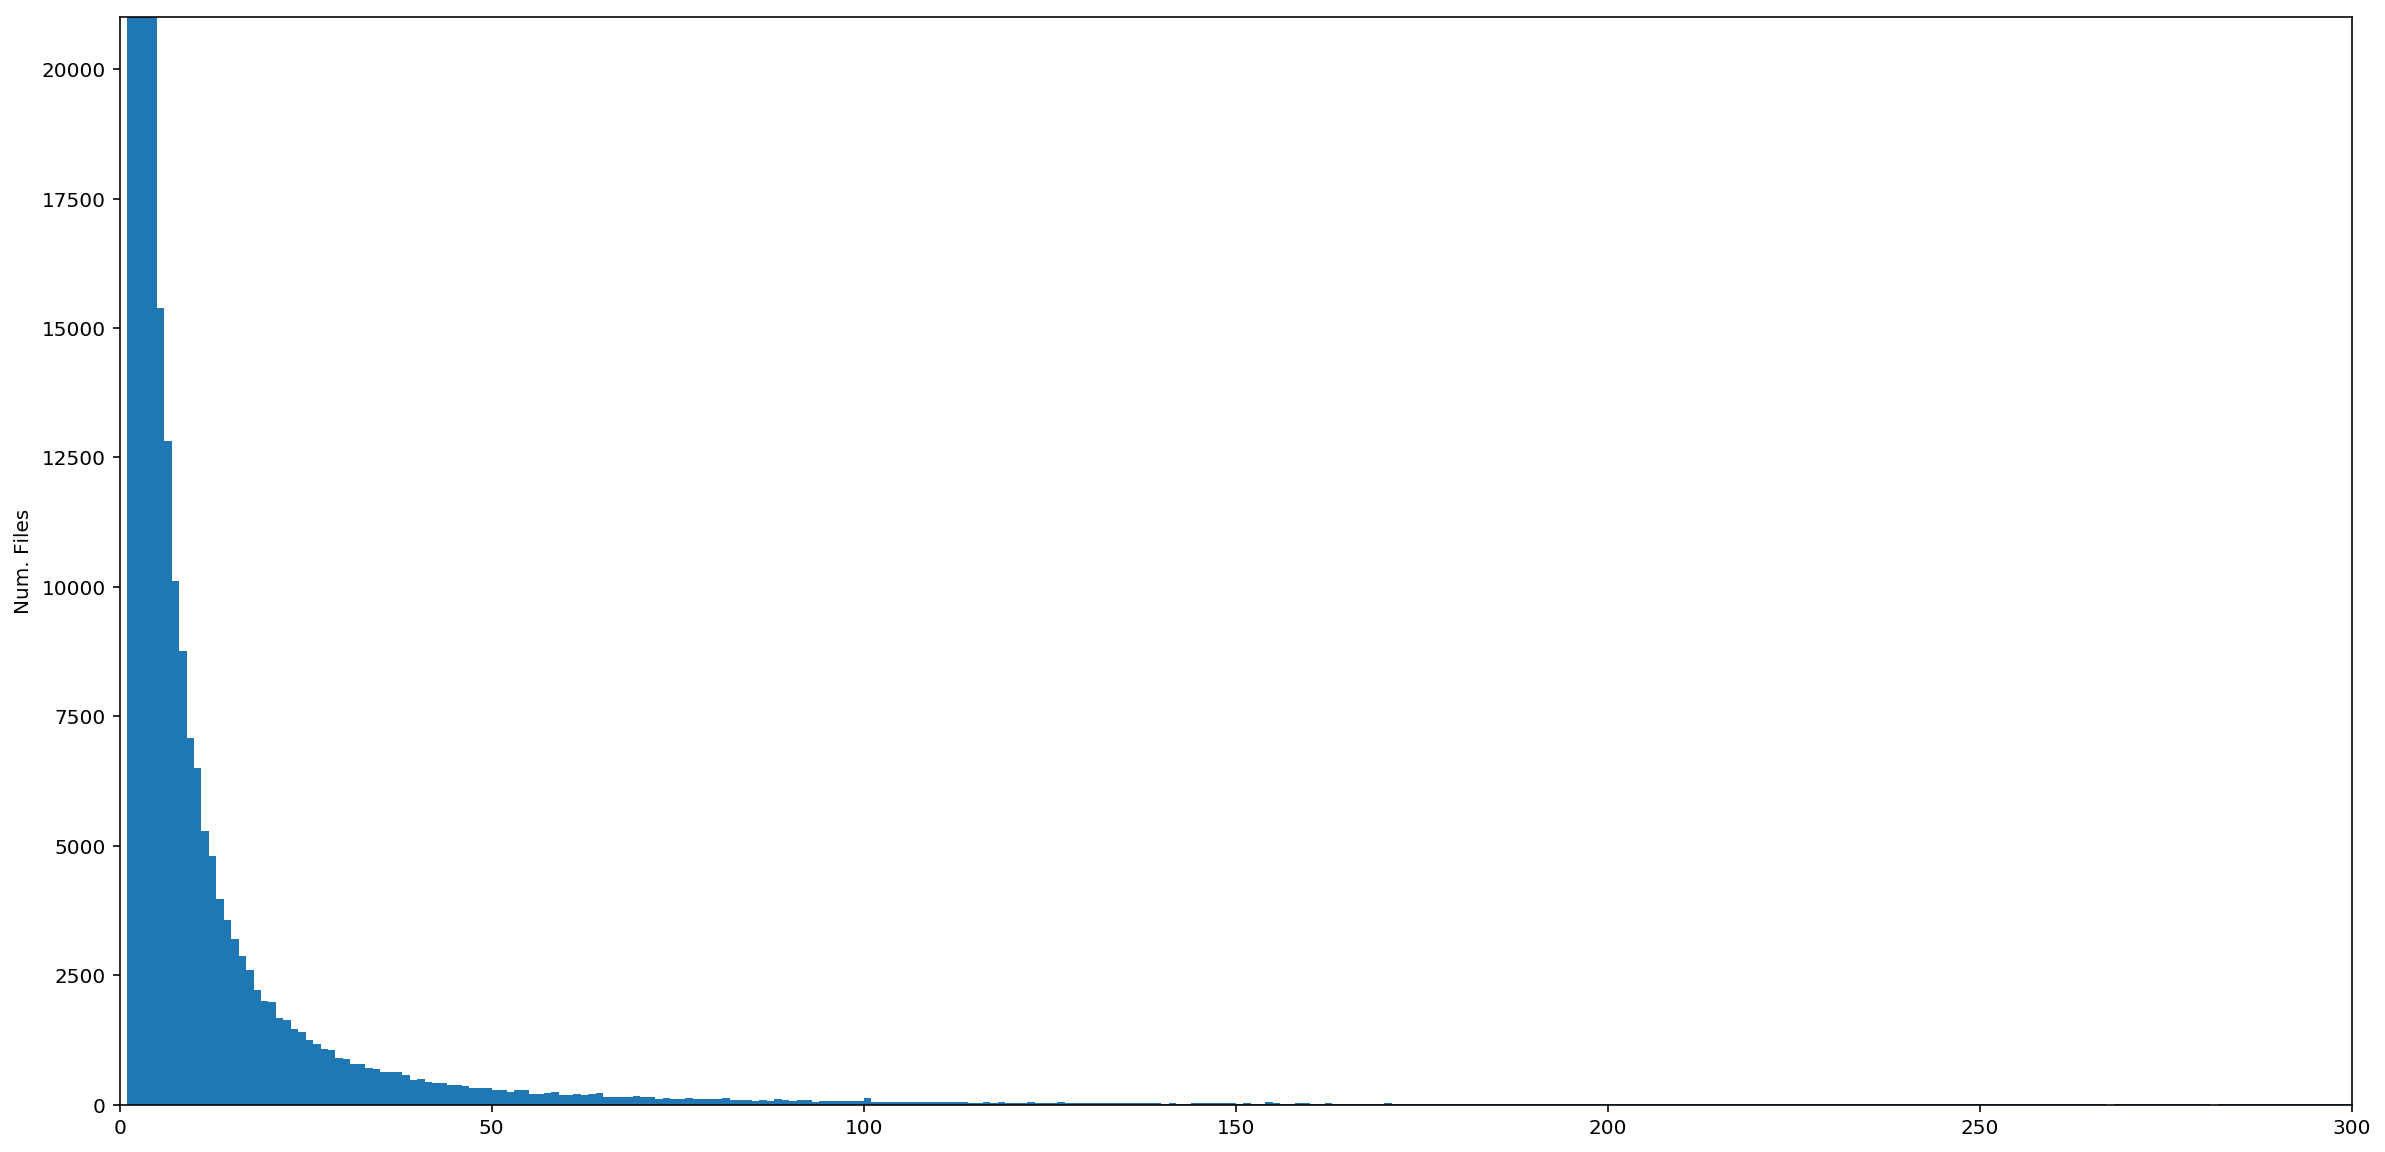

In [178]:
def actions2sentence(datas):
    data_total = []
    for files in datas:
        data4file = []
        for roots in files:
            sentence = ' '.join(roots)
            data4file.append(sentence)
        data_total.append(data4file)
    return data_total


training_data = actions2sentence(datas)

def get_seqlength(training_data):
    max_root_len = 0
    seqlength_list = []
    for items in training_data:
        for item in items:
            seqlength_list.append(len(item.split(" ")))
            if len(item.split(" ")) >  max_root_len: 
                max_root_len = len(item.split(" "))
    return max_root_len, seqlength_list

def plot_hist(seqlength_list):
    plt.figure(figsize=(20,10))
    number_of_files = np.array(seqlength_list)
    bincount = np.bincount(seqlength_list)
    x = np.arange(1, len(bincount)+1)
    n, bins, patches = plt.hist(seqlength_list,x)
    plt.ylabel("Num. Files")
    plt.xlim((0, 300))
    plt.ylim((0, 21000))

max_seqlength, sequence_list = get_seqlength(training_data)
print("<sample training data>: ", training_data[0])
plot_hist(sequence_list)

In [179]:
def check_index_strange_words(training_data):
    for i, item in enumerate(training_data):
        for j, file in enumerate(item):
            for k, action in enumerate(file.split()):
                index = dic.get(action)
                if index is None: # for debug 
                    print("==============================")
                    print(action) # for debug 
                    print('commits index: %d'%i)
                    print('file: %d'%j)
                    print('action: %d'%k)
check_index_strange_words(training_data)

In [180]:
def concat_train_data(training_data): 
    concat_data = ""
    tmp_list = []
    for items in training_data: 
        tmp_list += items
    concat_data = " ".join(tmp_list)
    return concat_data
    
def tokenize_train_data(concat_train_data, dic): 
    data = []
    for word in concat_train_data.split():
        index = dic.get(word)
        if index is None: # for debug 
            print(word) # for debug 
        data.append(index)
    return data

tokenized_data = concat_train_data(training_data)
print(type(tokenized_data))
tokenized_data = tokenize_train_data(tokenized_data, dic)
print(tokenized_data[:10])

<class 'str'>
[62, 62, 155, 53, 799, 579, 139, 9, 164, 62]


## Subsampling 
Here we apply subsampling to get rid of roots such as "UPDATE", "INS_Method", which show up frequently in the dataset 
and could affect training speed and also the quality if the embeddings. The subsampling employed here is by Mikolov the creator of word2vec. For each root ri in the training set, we discard it with probability given by p(ri) = 1 - sqrt(1/(f(ri)).

In [181]:
def subsample(tokenized_data): 
    """
    Remove frequently occuring roots for faster training and better representation. 
    For the subsampling I am implementing Mikolov's negative.
    For each root ri it will discard it with the given probability p(ri) = 1 - sqrt(1/(f(ri)).
    :param tokenized_data: A list that contains the position in of each root in all commits into a single document 
    """
    threshold = 1e-5
    roots_count = Counter(tokenized_data)
    total_count = len(tokenized_data)
    freqs = {root: count/total_count for root, count in roots_count.items()}
    p_drop = {root: 1 - np.sqrt(threshold/freqs[root]) for root in roots_count}
    sampled_roots = [root for root in tokenized_data if random.random() < (1 - p_drop[root])]
    return sampled_roots 

sampled_roots = subsample(tokenized_data)
print(len(tokenized_data))
print(len(sampled_roots))

3032748
128611


## Make Batches 

In [182]:
def get_targets(roots, idx, window_size=8): 
    """
    Here we set window_size = 5 and select randomly a number N in the range (1:N)
    and then use N roots to current root and currnent + N roots in the future... reference roots as "words"
    :param roots: batch of sampled tokenized roots 
    :param idx: batch index 
    :param window_size: skip-gram window size -- HYPERPARAMETER 
    
    """
    N = np.random.randint(1, window_size + 1)
    start = idx - N if (idx - N) > 0 else 0 
    stop = idx + N
    targets = set(roots[start:idx] + roots[idx+1:stop+1])
    return list(targets)

In [183]:
def generate_batchs(roots, batch_size, window_size=8): 
    n_batches = len(roots)//batch_size 
    
    # make sure to select full batches 
    roots = roots[:n_batches * batch_size]
    
    for idx in range(0, len(roots), batch_size): 
        i, j = [], []
        batch = roots[idx:idx+batch_size]
        for ii in range(len(batch)): 
            batch_i = batch[ii]
            batch_j = get_targets(batch, ii, window_size)
            i.extend([batch_i] * len(batch_j))
            j.extend(batch_j)
        yield i, j

In [184]:
def print_sample_batch(tokenized_data=sampled_roots[:100]): 
    for ii in range(1): 
        batches = generate_batchs(tokenized_data, 10, 10)
        for i, j in batches: 
            print("epoch {}".format(ii))
            print("length of roots: {}".format(len(i)))
            print("roots: ")
            print(i)
            print("---------------")
            print("labels: ")
            print(np.array(j)[:, None])
            print(" ")
print_sample_batch()

epoch 0
length of roots: 70
roots: 
[579, 579, 579, 579, 579, 579, 579, 579, 770, 770, 770, 770, 770, 770, 770, 770, 770, 330, 330, 330, 330, 330, 330, 330, 330, 330, 385, 385, 380, 380, 380, 380, 380, 380, 380, 380, 380, 279, 279, 279, 279, 279, 279, 261, 261, 261, 261, 261, 261, 261, 261, 261, 419, 419, 532, 532, 532, 532, 532, 532, 532, 405, 405, 405, 405, 405, 405, 405, 405, 405]
---------------
labels: 
[[385]
 [770]
 [419]
 [261]
 [330]
 [532]
 [279]
 [380]
 [385]
 [579]
 [419]
 [261]
 [330]
 [532]
 [405]
 [279]
 [380]
 [385]
 [770]
 [579]
 [419]
 [261]
 [532]
 [405]
 [279]
 [380]
 [330]
 [380]
 [385]
 [770]
 [579]
 [419]
 [261]
 [330]
 [532]
 [405]
 [279]
 [385]
 [419]
 [261]
 [330]
 [532]
 [380]
 [385]
 [770]
 [579]
 [419]
 [330]
 [532]
 [405]
 [279]
 [380]
 [532]
 [261]
 [385]
 [419]
 [261]
 [330]
 [405]
 [279]
 [380]
 [385]
 [770]
 [579]
 [419]
 [261]
 [330]
 [532]
 [279]
 [380]]
 
epoch 0
length of roots: 48
roots: 
[161, 161, 161, 161, 161, 161, 161, 161, 155, 155, 155, 155

### Hyperparameters 

In [185]:
learning_rate = 0.001
vocab_size = len(dic)   ##881 vocabulary size 
rate = 0.4 # dropout_rate = 1 - rate 
embedding_size = 300  # number of embedding features 
num_sampled = 16 # number of negative examples to sample
epochs = 100
batch_size = 256
window_size = 10

#Select random sample of most frequent words for model validation 
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.

print("vocabulary size ", vocab_size)

vocabulary size  831


## Build Network 
Input words are passed in as one-hot encoded vectors, which feed into a single hidden linear layer. 
The output of the embedding matrix of this network will then be fed into a CNN for prediction later on. 

### Initialize Graph
We have varying input sizes so we set the dimenision to **None** and the second dimension of the 
labels to **None** as well.

In [186]:
train_graph = tf.Graph()
with train_graph.as_default(): 
    inputs = tf.placeholder(tf.int32, [None], name="inputs")
    labels = tf.placeholder(tf.int32, [None, None], name="labels")

### Embedding 
Here the embedding matrix has the dimensions --> (tokenized_data X hidden_layers == embedding_size)

In [187]:
with train_graph.as_default(): 
    embedding = tf.Variable(tf.random_uniform((vocab_size, embedding_size), -1, 1))
    embedding = tf.nn.dropout(embedding, keep_prob=1 - rate, noise_shape=[vocab_size, 1])
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative Sampling (Softmax Loss)

**Note**: Do not run Softmax Loss and NCE cells at the same time.<br/>
*Talking point*: why does does softmax loss perform better than NCE on roots

#### Difference between softmax loss and NCE
Sample softmax is all about selecting a sample of the given number and try to get the softmax loss. Here the main objective is to make the result of the sampled softmax equal to our true softmax. So algorithm basically concentrate lot on selecting the those samples from the given distribution. On other hand NCE loss is more of selecting noise samples and try to mimic the true softmax. It will take only one true class and a K noise classes

In [188]:
with train_graph.as_default(): 
    softmax_weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=0.1))
    softmax_biases = tf.Variable(tf.zeros([vocab_size]))
    loss = tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, labels=labels, inputs=embed, \
                                      num_sampled=num_sampled, num_classes=vocab_size)
    loss=tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

### Negative Sampling (NCE)

In [189]:
# with train_graph.as_default(): 
#     nce_weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
#     nce_biases = tf.Variable(tf.zeros([vocab_size]))
#     loss = tf.reduce_mean(
#         tf.nn.nce_loss(
#             weights=nce_weights, 
#             biases=nce_biases, 
#             labels=labels, 
#             inputs=embed, 
#             num_sampled=num_sampled, 
#             num_classes=vocab_size
#         )
#     )
#     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss) 

## Validation
pick most common and least common roots 

In [190]:
with train_graph.as_default(): 
    ## From Thusan Ganegedara's implementation 
    
    # pick top 8 samples from (0, 100) and (600, 700) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, random.sample(range(100, 600+valid_window), valid_size//2))
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # use cosine distance 
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
    normalized_embedding = embedding/norm 
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [191]:
# if the checkpoints directory does not exist then make it 
!mkdir checkpoints 

A subdirectory or file checkpoints already exists.


In [192]:
with train_graph.as_default(): 
    saver = tf.train.Saver()
with tf.Session(graph=train_graph) as sess:
    step = 1
    avg_loss = 0
    sess.run(tf.global_variables_initializer())
    for ii in range(1, epochs+1): 
        batches = generate_batchs(sampled_roots, batch_size, window_size)
        start = time.time()
        for i, j in batches: 
            feed = {inputs: i, labels: np.array(j)[:, None]}
            train_loss, _ = sess.run([loss, optimizer], feed_dict=feed)
            avg_loss += train_loss 
            if step % 100 == 0: 
                # Mat Leonard implementation 
                end = time.time()
                print("Epoch {}/{}".format(ii, epochs), 
                     "Iteration: {}".format(step), 
                     "Avg. Training loss: {:.4f}".format(avg_loss/100), 
                     "{:.4f} sec/batch".format((end - start)/100))
                avg_loss = 0
                start = time.time()
            if step % 10000 == 0: 
                sim = similarity.eval()
                for idx in range(valid_size): 
                    valid_word = rev_dic[valid_examples[idx]]
                    top_k = 8
                    nearest = (-sim[idx, :]).argsort()[1:top_k+1]
                    log = "Nearest to %s:" % valid_word 
                    for k in range(top_k):
                        close_word = rev_dic[nearest[k]]
                        log = "%s %s" % (log, close_word)
                    print(log)
                    print("\n")
            step += 1
    save_path = saver.save(sess, "checkpoints/word_embeddings.ckpt")
    embed_mat = sess.run(normalized_embedding)
                    
                
        

Epoch 1/100 Iteration: 100 Avg. Training loss: 2.5653 0.0105 sec/batch
Epoch 1/100 Iteration: 200 Avg. Training loss: 2.4337 0.0077 sec/batch
Epoch 1/100 Iteration: 300 Avg. Training loss: 2.2015 0.0077 sec/batch
Epoch 1/100 Iteration: 400 Avg. Training loss: 2.1729 0.0078 sec/batch
Epoch 1/100 Iteration: 500 Avg. Training loss: 2.1199 0.0082 sec/batch
Epoch 2/100 Iteration: 600 Avg. Training loss: 2.0327 0.0080 sec/batch
Epoch 2/100 Iteration: 700 Avg. Training loss: 2.0033 0.0083 sec/batch
Epoch 2/100 Iteration: 800 Avg. Training loss: 1.9084 0.0083 sec/batch
Epoch 2/100 Iteration: 900 Avg. Training loss: 1.8752 0.0082 sec/batch
Epoch 2/100 Iteration: 1000 Avg. Training loss: 1.9097 0.0081 sec/batch
Epoch 3/100 Iteration: 1100 Avg. Training loss: 1.8465 0.0075 sec/batch
Epoch 3/100 Iteration: 1200 Avg. Training loss: 1.8473 0.0083 sec/batch
Epoch 3/100 Iteration: 1300 Avg. Training loss: 1.7227 0.0082 sec/batch
Epoch 3/100 Iteration: 1400 Avg. Training loss: 1.7549 0.0080 sec/batch
E

Epoch 21/100 Iteration: 10100 Avg. Training loss: 1.4525 0.0052 sec/batch
Epoch 21/100 Iteration: 10200 Avg. Training loss: 1.5031 0.0082 sec/batch
Epoch 21/100 Iteration: 10300 Avg. Training loss: 1.4649 0.0081 sec/batch
Epoch 21/100 Iteration: 10400 Avg. Training loss: 1.3360 0.0084 sec/batch
Epoch 21/100 Iteration: 10500 Avg. Training loss: 1.4117 0.0079 sec/batch
Epoch 22/100 Iteration: 10600 Avg. Training loss: 1.5572 0.0047 sec/batch
Epoch 22/100 Iteration: 10700 Avg. Training loss: 1.4408 0.0078 sec/batch
Epoch 22/100 Iteration: 10800 Avg. Training loss: 1.4440 0.0078 sec/batch
Epoch 22/100 Iteration: 10900 Avg. Training loss: 1.4381 0.0080 sec/batch
Epoch 22/100 Iteration: 11000 Avg. Training loss: 1.4352 0.0079 sec/batch
Epoch 23/100 Iteration: 11100 Avg. Training loss: 1.5567 0.0044 sec/batch
Epoch 23/100 Iteration: 11200 Avg. Training loss: 1.4320 0.0091 sec/batch
Epoch 23/100 Iteration: 11300 Avg. Training loss: 1.4379 0.0081 sec/batch
Epoch 23/100 Iteration: 11400 Avg. Tra

Epoch 41/100 Iteration: 20100 Avg. Training loss: 1.3718 0.0016 sec/batch
Epoch 41/100 Iteration: 20200 Avg. Training loss: 1.3888 0.0082 sec/batch
Epoch 41/100 Iteration: 20300 Avg. Training loss: 1.3063 0.0083 sec/batch
Epoch 41/100 Iteration: 20400 Avg. Training loss: 1.4227 0.0081 sec/batch
Epoch 41/100 Iteration: 20500 Avg. Training loss: 1.3177 0.0081 sec/batch
Epoch 42/100 Iteration: 20600 Avg. Training loss: 1.4268 0.0015 sec/batch
Epoch 42/100 Iteration: 20700 Avg. Training loss: 1.3591 0.0083 sec/batch
Epoch 42/100 Iteration: 20800 Avg. Training loss: 1.3414 0.0083 sec/batch
Epoch 42/100 Iteration: 20900 Avg. Training loss: 1.3117 0.0085 sec/batch
Epoch 42/100 Iteration: 21000 Avg. Training loss: 1.2773 0.0085 sec/batch
Epoch 43/100 Iteration: 21100 Avg. Training loss: 1.3805 0.0014 sec/batch
Epoch 43/100 Iteration: 21200 Avg. Training loss: 1.3682 0.0083 sec/batch
Epoch 43/100 Iteration: 21300 Avg. Training loss: 1.3932 0.0086 sec/batch
Epoch 43/100 Iteration: 21400 Avg. Tra

Epoch 60/100 Iteration: 30100 Avg. Training loss: 1.2785 0.0087 sec/batch
Epoch 61/100 Iteration: 30200 Avg. Training loss: 1.4243 0.0069 sec/batch
Epoch 61/100 Iteration: 30300 Avg. Training loss: 1.3370 0.0089 sec/batch
Epoch 61/100 Iteration: 30400 Avg. Training loss: 1.2844 0.0088 sec/batch
Epoch 61/100 Iteration: 30500 Avg. Training loss: 1.3571 0.0089 sec/batch
Epoch 61/100 Iteration: 30600 Avg. Training loss: 1.3037 0.0085 sec/batch
Epoch 62/100 Iteration: 30700 Avg. Training loss: 1.4162 0.0061 sec/batch
Epoch 62/100 Iteration: 30800 Avg. Training loss: 1.3970 0.0087 sec/batch
Epoch 62/100 Iteration: 30900 Avg. Training loss: 1.3393 0.0091 sec/batch
Epoch 62/100 Iteration: 31000 Avg. Training loss: 1.3559 0.0087 sec/batch
Epoch 62/100 Iteration: 31100 Avg. Training loss: 1.3617 0.0090 sec/batch
Epoch 63/100 Iteration: 31200 Avg. Training loss: 1.3922 0.0067 sec/batch
Epoch 63/100 Iteration: 31300 Avg. Training loss: 1.3581 0.0090 sec/batch
Epoch 63/100 Iteration: 31400 Avg. Tra

Epoch 80/100 Iteration: 40100 Avg. Training loss: 1.3081 0.0089 sec/batch
Epoch 81/100 Iteration: 40200 Avg. Training loss: 1.3290 0.0035 sec/batch
Epoch 81/100 Iteration: 40300 Avg. Training loss: 1.3244 0.0087 sec/batch
Epoch 81/100 Iteration: 40400 Avg. Training loss: 1.3341 0.0090 sec/batch
Epoch 81/100 Iteration: 40500 Avg. Training loss: 1.2672 0.0088 sec/batch
Epoch 81/100 Iteration: 40600 Avg. Training loss: 1.3736 0.0088 sec/batch
Epoch 82/100 Iteration: 40700 Avg. Training loss: 1.3073 0.0035 sec/batch
Epoch 82/100 Iteration: 40800 Avg. Training loss: 1.2790 0.0084 sec/batch
Epoch 82/100 Iteration: 40900 Avg. Training loss: 1.2797 0.0082 sec/batch
Epoch 82/100 Iteration: 41000 Avg. Training loss: 1.3368 0.0084 sec/batch
Epoch 82/100 Iteration: 41100 Avg. Training loss: 1.3117 0.0085 sec/batch
Epoch 83/100 Iteration: 41200 Avg. Training loss: 1.2887 0.0032 sec/batch
Epoch 83/100 Iteration: 41300 Avg. Training loss: 1.3153 0.0085 sec/batch
Epoch 83/100 Iteration: 41400 Avg. Tra

Epoch 100/100 Iteration: 50100 Avg. Training loss: 1.3201 0.0085 sec/batch
Epoch 100/100 Iteration: 50200 Avg. Training loss: 1.2987 0.0083 sec/batch


## Restore Embedding Matrix checkpoint 
This ensure that last training session is always used 

In [208]:
with train_graph.as_default(): 
    saver = tf.train.Saver()
with tf.Session(graph=train_graph) as sess: 
    saver.restore(sess, tf.train.latest_checkpoint("checkpoints"))
    embed_mat = sess.run(embedding)
print(embed_mat.shape[1])

INFO:tensorflow:Restoring parameters from checkpoints\word_embeddings.ckpt
300


## Store Pre-Trained Embeddings 
Pre-Trained Embeddings are stored in .txt file and used later on for looking up test embeddings.<br/>
  **Note**: The previous embedding.txt file is deleted an re-written, with current checkpoint.<br/>
  You need to execute **HYPERPARAMETERS** section to get *vocab_size*

In [209]:
embedding_filename = "embedding.txt"
pad_token = "<PAD/>"
if os.path.exists(embedding_filename): 
    os.remove(embedding_filename)
else:
    with open(embedding_filename, "w") as f:
        pad_embed = np.zeros(embed_mat.shape[1])
        for i in range(vocab_size): 
            _embed = embed_mat[i, :]
            embedded_word = rev_dic[i]
            f.write("%s %s\n"%(embedded_word, " ".join(map(str, _embed))))
        f.write("%s %s\n"%(pad_token, " ".join(map(str, pad_embed))))

## Vizualize Data 

In [210]:
%config InlineBackend.figure_format = "retina"
from sklearn.manifold import TSNE 

def viz_data(embed_mat, reverse_dictionary, n_viz=20): 
    tsne = TSNE()
    embed_tsne = tsne.fit_transform(embed_mat[:n_viz, :])
    fig, ax  = plt.subplots(figsize=(14, 14))
    for idx in range(n_viz): 
        plt.scatter(*embed_tsne[idx, :], color="#ff8243")
        plt.annotate(reverse_dictionary[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

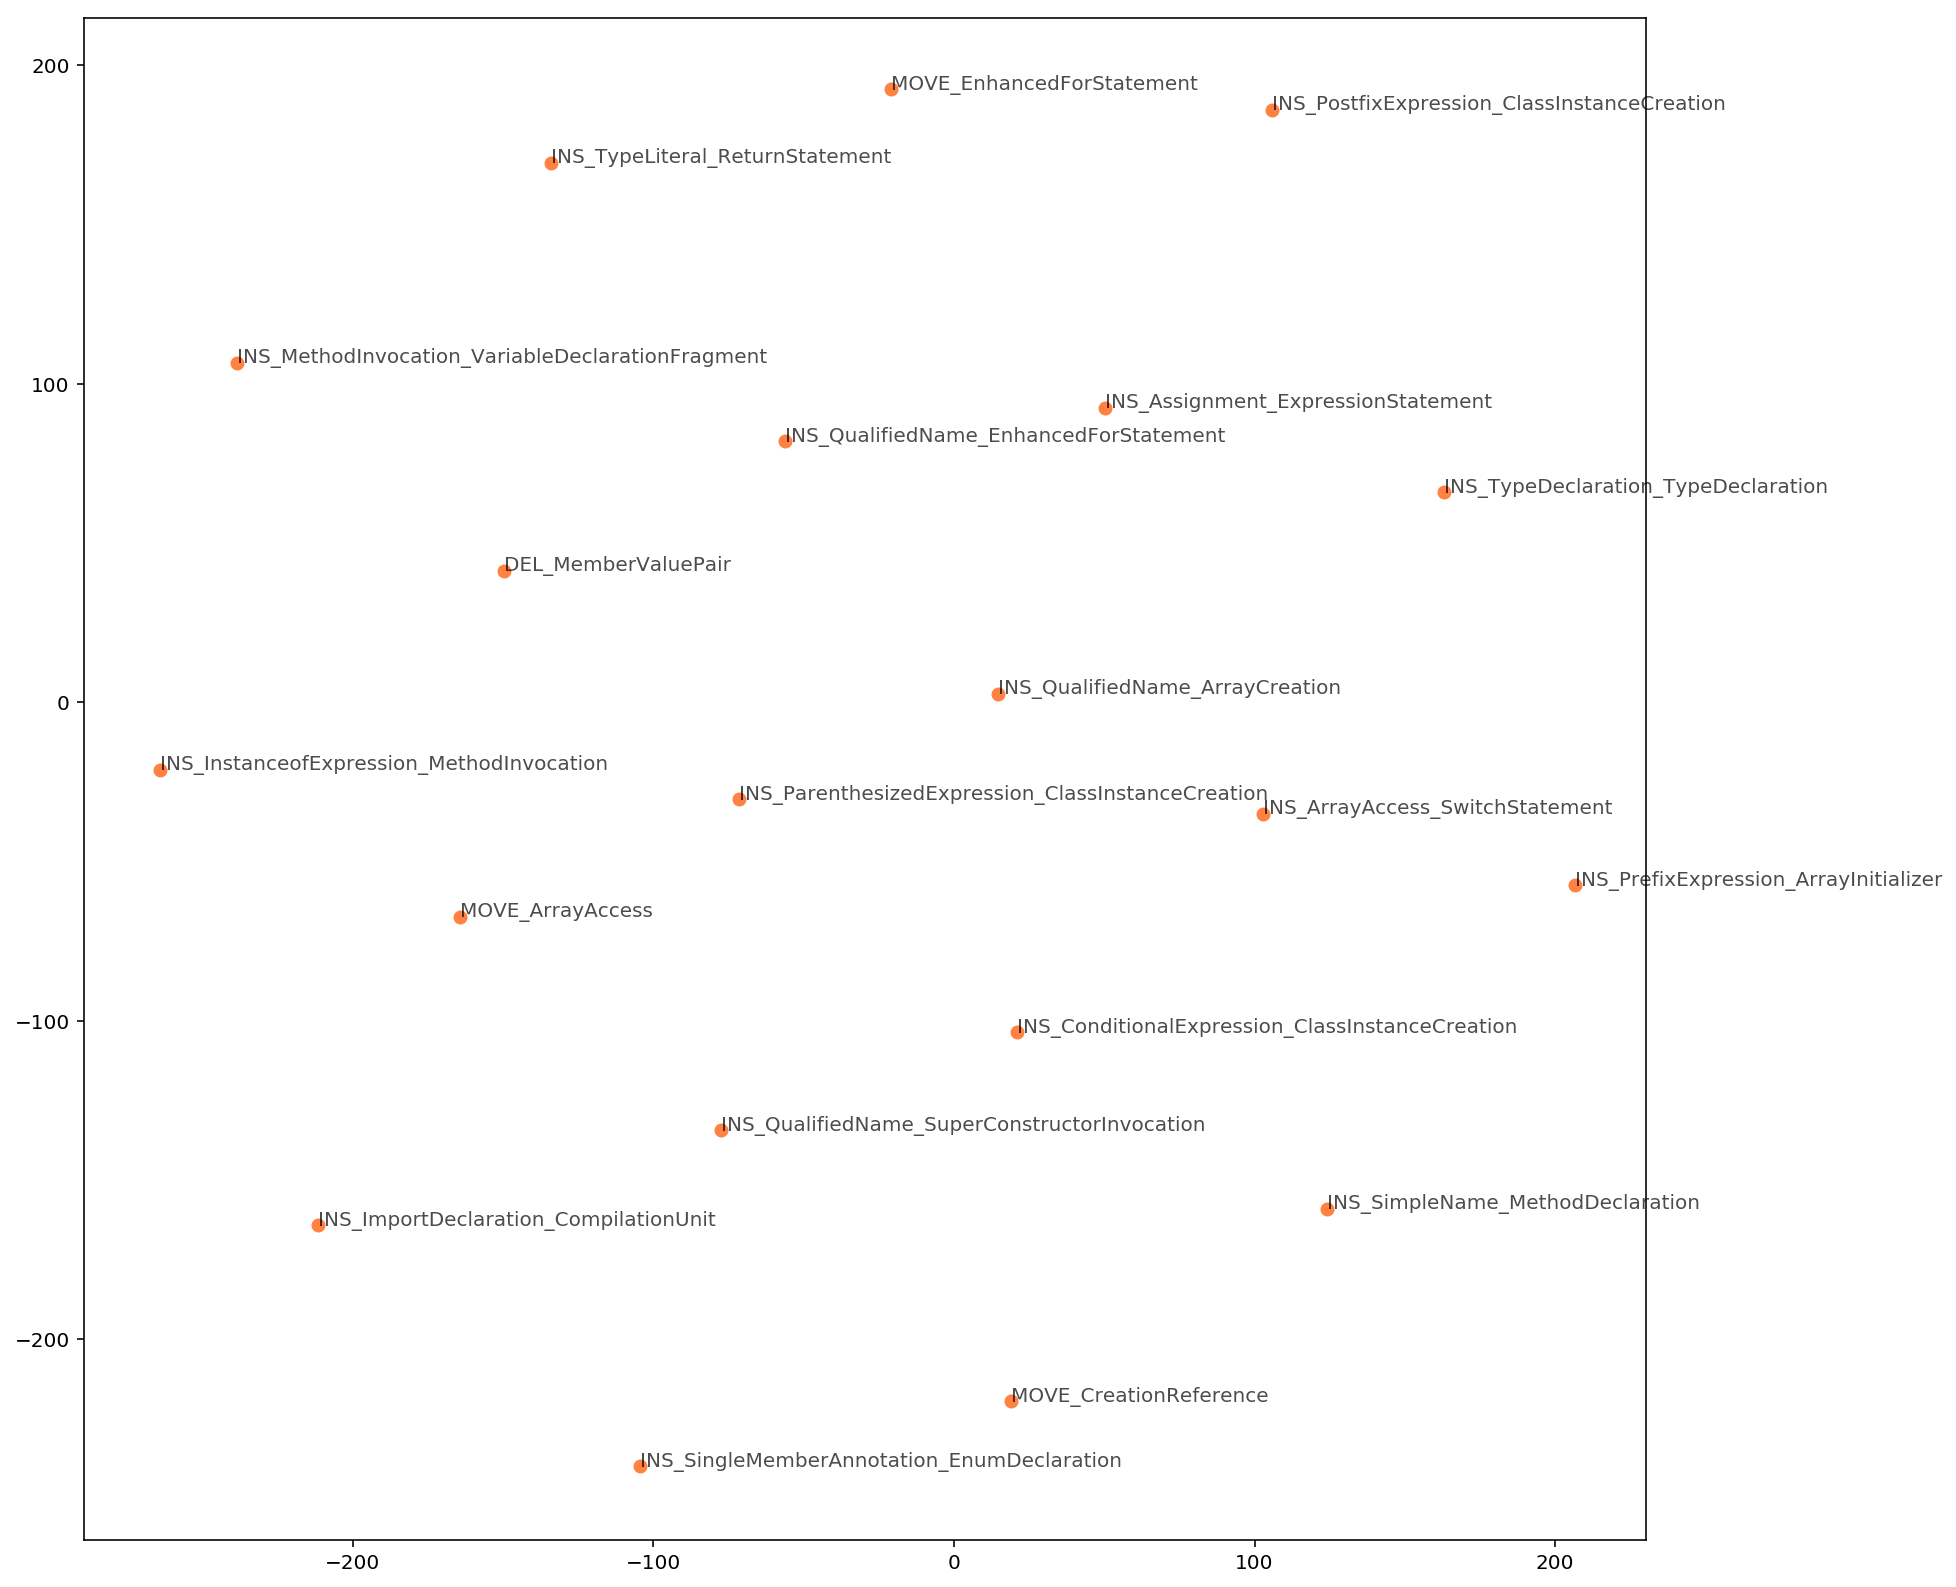

In [211]:
# Visualize pretrain data: 
viz_data(embed_mat, rev_dic)

## Embedding Layer Utility Functions 
Here we define three functions to: 
- load embeddings as a dict 
- create a weight matrix for the Embedding layer from a loaded model 

In [212]:
def load_embedding(filename):
    """
    load embedding as python dictionary {root<str>: embeddings<np_array>}
    :param filename: embedding.txt 
    :return: dictionary object mapping root to embeddings 
    """
    if not os.path.exists(filename): 
        print("please run 'Store Pre-Trained Embeddings Cell!'")
    else: 
        with open(filename, "r") as f: 
            lines = f.readlines()
            f.close()
            # create map of words to vectors 
            embedding = dict()
            for line in lines: 
                comp = line.split()
                # map of <str, numpy array> 
                embedding[comp[0]] = np.asarray(comp[1:], dtype='float32')
            return embedding 

def get_weight_matrix(embedding, test_dic, embedding_size):
    """
    Create a weight matrix for the embedding layer from the Pre-Trained Embeddings 
    :param embedding: Pre-Trained emneddings dictionary 
    :param test_dic: vocabulary for test file 
    :param embedding_size: number of hidden layers, which can be found in HYPERPARAMETERS section 
    :return: embedding matrix of test file 
    """
    vocab_size = len(test_dic)
    # initialize embedding matrix with zeros for efficiency 
    embed_mat = np.zeros((vocab_size, embedding_size))
    # store vectors using the test dictionary integer mapping 
    for word, idx in test_dic.items(): 
        embed_mat[i] = embedding.get(word)
    return embed_mat

In [213]:
pre_embed = load_embedding("embedding.txt")
for k in pre_embed.keys(): 
    print(k)

INS_PrefixExpression_ArrayInitializer
INS_InfixExpression_WhileStatement
INS_QualifiedName_EnhancedForStatement
INS_ConditionalExpression_ClassInstanceCreation
INS_QualifiedName_InstanceofExpression
MOVE_EnhancedForStatement
INS_VariableDeclarationExpression_TryStatement
INS_TypeLiteral_ReturnStatement
MOVE_CreationReference
INS_ImportDeclaration_CompilationUnit
INS_TypeDeclaration_TypeDeclaration
INS_MethodInvocation_VariableDeclarationFragment
INS_SimpleName_MethodDeclaration
DEL_MemberValuePair
INS_ParenthesizedExpression_ClassInstanceCreation
INS_ArrayAccess_SwitchStatement
INS_QualifiedName_SuperConstructorInvocation
INS_QualifiedName_ArrayCreation
INS_InstanceofExpression_MethodInvocation
MOVE_ArrayAccess
INS_MethodInvocation_CastExpression
INS_Modifier_FieldDeclaration
INS_ParenthesizedExpression_IfStatement
MOVE_EnumDeclaration
DEL_CatchClause
INS_StringLiteral_ConstructorInvocation
INS_ConditionalExpression_IfStatement
DEL_VariableDeclarationExpression
INS_SimpleType_Annotatio